## XGBoost Model for OSM Changeset Data

In [3]:
import xgboost
print(xgboost.__version__)


2.1.2


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%reload_ext autoreload

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

### Create directories required for the code

In [7]:
import os

# Define the directory and file path for saving the model
save_dir = '../saved_parameters/changeset_model/'
model_file = os.path.join(save_dir, 'final_xgboost_model.pkl')

# Check if the directory exists, else create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory created at: {save_dir}")
else:
    print(f"Directory already exists at: {save_dir}")

Directory already exists at: ../saved_parameters/changeset_model/


### Load the data set into a data frame

In [8]:
features_df = pd.read_parquet("../data/changeset_data/osm_labelled_changeset_features_with_user_info.parquet")

#Shuffle the data entries
features_df = features_df.sample(frac=1, random_state=42).reset_index(drop=True)
features_df.head()

,changeset_id,created_at,closed_at,user,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,...,label,no_nodes,no_ways,no_relations,no_creates,no_modifications,no_deletions,uid,account_created,changes_count
0,55841613,2018-01-28 21:16:49+00:00,2018-01-28 21:16:49+00:00,clauslide,7528900,1,-33.546025,-71.606199,-33.545570,-71.605570,...,True,0,1,0,1,0,0,7528900,2018-01-26T06:58:01Z,0
1,45459256,2017-01-25 03:29:43+00:00,2017-01-25 03:29:44+00:00,Eye of the Squid,5186084,5,43.779429,-79.337066,43.780136,-79.336516,...,True,4,1,0,5,0,0,5186084,2017-01-25T02:47:25Z,0
2,31041378,2015-05-12 09:18:59+00:00,2015-05-12 09:18:59+00:00,maartinez,1738975,1,53.661516,14.608453,53.663647,14.609384,...,False,0,1,0,0,1,0,1738975,2013-09-09T09:10:27Z,0
3,58344034,2018-04-23 16:22:00+00:00,2018-04-23 16:22:00+00:00,dankpoet,4175482,5,12.129619,99.002683,12.129719,99.002799,...,False,4,1,0,5,0,0,4175482,2016-06-26T22:16:00Z,0
4,25666885,2014-09-25 14:45:21+00:00,2014-09-25 14:45:22+00:00,wsay22,1464076,1,54.778566,9.438529,54.778566,9.438529,...,True,1,0,0,0,1,0,1464076,2013-05-19T09:12:59Z,0


### Drop unnecessary columns and replace spaces with underscores

In [9]:
if features_df.columns.__contains__('geometry'):
    features_df.drop('geometry', axis=1, inplace=True)

if features_df.columns.__contains__('changeset_id'):
    features_df.drop('changeset_id', axis=1, inplace=True)

if features_df.columns.__contains__('created_at'):
    features_df.drop('created_at', axis=1, inplace=True)

if features_df.columns.__contains__('user'):
    features_df.drop('user', axis=1, inplace=True)
    
#TODO: Analyse comment and detect if suspicious. Can get a new feature like comment suspicious score.
if features_df.columns.__contains__('comment'):
    features_df.drop('comment', axis=1, inplace=True)

if features_df.columns.__contains__('uid'):
    features_df.drop('uid', axis=1, inplace=True)

if features_df.columns.__contains__('changes_count'):
    features_df.drop('changes_count', axis=1, inplace=True)

features_df.columns = features_df.columns.str.replace(' ', '_', regex=True)

#TODO: Also add user features or user reliability score.
#TODO: Also check about previous object features.

features_df.head()

,closed_at,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,created_by,label,no_nodes,no_ways,no_relations,no_creates,no_modifications,no_deletions,account_created
0,2018-01-28 21:16:49+00:00,7528900,1,-33.546025,-71.606199,-33.545570,-71.605570,iD 2.6.0,True,0,1,0,1,0,0,2018-01-26T06:58:01Z
1,2017-01-25 03:29:44+00:00,5186084,5,43.779429,-79.337066,43.780136,-79.336516,iD 2.0.2,True,4,1,0,5,0,0,2017-01-25T02:47:25Z
2,2015-05-12 09:18:59+00:00,1738975,1,53.661516,14.608453,53.663647,14.609384,iD 1.7.2,False,0,1,0,0,1,0,2013-09-09T09:10:27Z
3,2018-04-23 16:22:00+00:00,4175482,5,12.129619,99.002683,12.129719,99.002799,iD 2.8.0,False,4,1,0,5,0,0,2016-06-26T22:16:00Z
4,2014-09-25 14:45:22+00:00,1464076,1,54.778566,9.438529,54.778566,9.438529,iD 1.5.4,True,1,0,0,0,1,0,2013-05-19T09:12:59Z


### One-hot Encoding

In [10]:
# filtered_changesets = features_df[features_df['changeset_id'] == 31867220]
# 
# Print the resulting DataFrame
# filtered_changesets.head()

In [11]:
X = features_df.drop('label', axis=1).copy()
y = features_df['label'].copy()

X['closed_at'] = pd.to_datetime(X['closed_at']).astype(int) / 10**9
X['account_created'] = pd.to_datetime(X['account_created']).astype(int) / 10**9

X_encoded = pd.get_dummies(X, columns=['created_by'])

assert X_encoded.dtypes.__contains__('object') == False
X_encoded.head()

,closed_at,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,no_nodes,no_ways,no_relations,...,created_by_reverter;JOSM/1.5 (14945 uk),created_by_reverter_plugin/34977;JOSM/1.5 (15031 en),created_by_reverter_plugin/34999;JOSM/1.5 (15155 de),created_by_reverter_plugin/35084;JOSM/1.5 (15492 en),created_by_rocketdata.io,created_by_rosemary v0.3.12,created_by_rosemary v0.4.4,created_by_simple_revert.py,created_by_streetkeysmv,created_by_upload.py v. 1
0,1.517174e+09,7528900,1,-33.546025,-71.606199,-33.545570,-71.605570,0,1,0,...,False,False,False,False,False,False,False,False,False,False
1,1.485315e+09,5186084,5,43.779429,-79.337066,43.780136,-79.336516,4,1,0,...,False,False,False,False,False,False,False,False,False,False
2,1.431422e+09,1738975,1,53.661516,14.608453,53.663647,14.609384,0,1,0,...,False,False,False,False,False,False,False,False,False,False
3,1.524501e+09,4175482,5,12.129619,99.002683,12.129719,99.002799,4,1,0,...,False,False,False,False,False,False,False,False,False,False
4,1.411656e+09,1464076,1,54.778566,9.438529,54.778566,9.438529,1,0,0,...,False,False,False,False,False,False,False,False,False,False


### Format y and check ratio of x:y

In [12]:
y = y.replace(True, 1)
y = y.replace(False, 0)
sum(y) / len(y)

C:\Users\Pavan\AppData\Local\Temp\ipykernel_36016\1318066108.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(False, 0)


0.500905051834787

### Split the data between train and test set & print statistics

In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, random_state=42, test_size=0.4, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, random_state=42, test_size=0.8, stratify=y_temp
)

# Get the shapes of the datasets
shapes = {
    'X_train shape': X_train.shape,
    'X_val shape': X_val.shape,
    'X_test shape': X_test.shape,
    'y_train shape': y_train.shape,
    'y_val shape': y_val.shape,
    'y_test shape': y_test.shape
}

# Convert shapes to DataFrame for better display
shapes_df = pd.DataFrame(shapes, index=['Number of Samples', 'Number of Features']).T
print("Dataset Shapes:")
print(shapes_df)
print()

# Calculate and display statistics for each dataset
def calculate_statistics(y, set_name):
    total = len(y)
    vandalism = sum(y)  # Assuming 'vandalism' is labeled as 1
    non_vandalism = total - vandalism
    ratio = vandalism / total

    print(f"{set_name} Statistics:\n"
          f"Total Samples: {total}\n"
          f"Vandalism: {vandalism}\n"
          f"Non-Vandalism: {non_vandalism}\n"
          f"Vandalism Ratio: {ratio:.4f}\n")

# Print statistics for train, validation, and test sets
calculate_statistics(y_train, "Train Set")
calculate_statistics(y_val, "Validation Set")
calculate_statistics(y_test, "Test Set")


Dataset Shapes:
               Number of Samples  Number of Features
X_train shape              10938                1459
X_val shape                 1458                1459
X_test shape                5835                1459
y_train shape              10938               10938
y_val shape                 1458                1458
y_test shape                5835                5835

Train Set Statistics:
Total Samples: 10938
Vandalism: 5479
Non-Vandalism: 5459
Vandalism Ratio: 0.5009

Validation Set Statistics:
Total Samples: 1458
Vandalism: 730
Non-Vandalism: 728
Vandalism Ratio: 0.5007

Test Set Statistics:
Total Samples: 5835
Vandalism: 2923
Non-Vandalism: 2912
Vandalism Ratio: 0.5009



### Model training with random hyperparameters and without cross validation

In [14]:
from model.xgboost_training import train_final_model, save_model
from model.hyper_parameter_search import get_random_parameters

# Generate random hyperparameters
random_parameters = get_random_parameters()

# Train Final Model with random parameters using training and validation sets
final_base_model = train_final_model(X_train, y_train, X_val, y_val, random_parameters)

# Save the Model
save_model(final_base_model, '../saved_parameters/changeset_model/final_xgboost_base_model.pkl')


Random Hyperparameters Generated: 

{'learning_rate': 0.3, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'lambda': 10, 'alpha': 5, 'min_child_weight': 10, 'gamma': 0, 'n_estimators': 60}



2024-11-16 20:40:16 - INFO - xgboost_training.py -- Model training complete.

2024-11-16 20:40:16 - INFO - xgboost_training.py -- Best iteration: 56

2024-11-16 20:40:16 - INFO - xgboost_training.py -- Best score (on validation set): 0.9093

2024-11-16 20:40:16 - INFO - xgboost_training.py -- Early stopping occurred. Model stopped after 56 iterations.

2024-11-16 20:40:16 - INFO - xgboost_training.py -- Model saved to ../saved_parameters/changeset_model/final_xgboost_base_model.pkl


### Base model evaluation


Train Set Evaluation
--------------------

Accuracy: 0.8395501919912233
AUC-ROC: 0.9163410354865908

Classification Report (Train):
                precision    recall  f1-score   support

Not Vandalism       0.83      0.85      0.84      5459
    Vandalism       0.85      0.83      0.84      5479

     accuracy                           0.84     10938
    macro avg       0.84      0.84      0.84     10938
 weighted avg       0.84      0.84      0.84     10938


Test Set Evaluation
-------------------

Accuracy: 0.81662382176521
AUC-ROC: 0.8966597570236811

Classification Report (Test):
                precision    recall  f1-score   support

Not Vandalism       0.81      0.83      0.82      2912
    Vandalism       0.82      0.81      0.81      2923

     accuracy                           0.82      5835
    macro avg       0.82      0.82      0.82      5835
 weighted avg       0.82      0.82      0.82      5835


AUC-PR Score on Test Set: 0.9017582101533941
ROC-AUC Score on Test Set

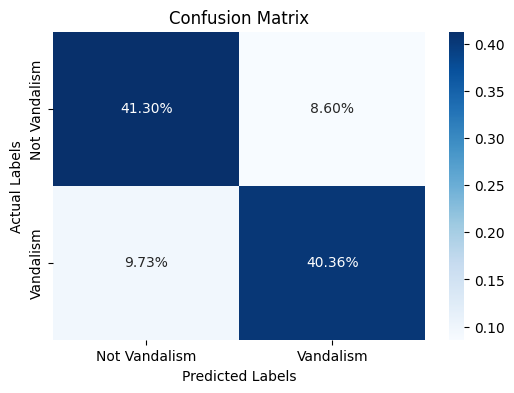

In [15]:
from evaluate_xgboost_model import (evaluate_train_test_metrics, calculate_auc_scores,
                                    plot_confusion_matrix)

# Evaluate Train and Test Metrics
y_test_pred, y_test_prob = evaluate_train_test_metrics(final_base_model, X_train, y_train, X_test, y_test)

# Calculate AUC Scores and Get Confusion Matrix
cm = calculate_auc_scores(y_test, y_test_pred, y_test_prob)

# Plot Confusion Matrix
plot_confusion_matrix(cm)

### Hyperparameter tuning with cross validation and model training with best parameters

In [16]:
from model.hyper_parameter_search import randomized_search_cv
from model.xgboost_training import train_final_model, save_model
from model.evaluate_xgboost_model import evaluate_model_with_cv

# Search and Load Hyperparameters
best_params = randomized_search_cv(X_train, y_train,  '../saved_parameters/changeset_model/best_hyperparameters.json')

# Train Final Model with best_params
final_tuned_model = train_final_model(X_train, y_train, X_val, y_val, best_params)

# (OPTIONAL): Perform Final Cross-Validation on Full Dataset
cv_scores = evaluate_model_with_cv(X_train, y_train, best_params)

# Save the Model
save_model(final_tuned_model, '../saved_parameters/changeset_model/final_xgboost_model_tuned.pkl')



2024-11-16 20:40:19 - INFO - hyper_parameter_search.py -- Hyperparameters file already exists.

2024-11-16 20:40:19 - INFO - load_hyper_parameters.py -- Loaded hyperparameters from ../saved_parameters/changeset_model/best_hyperparameters.json

2024-11-16 20:40:19 - INFO - hyper_parameter_search.py -- best hyper parameters: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 1.0, 'alpha': 1}

2024-11-16 20:40:23 - INFO - xgboost_training.py -- Model training complete.

2024-11-16 20:40:23 - INFO - xgboost_training.py -- Best iteration: 100

2024-11-16 20:40:23 - INFO - xgboost_training.py -- Best score (on validation set): 0.9499

2024-11-16 20:40:23 - INFO - xgboost_training.py -- No early stopping. Model trained for all 100 iterations.



Performing 5-fold Cross-Validation on the training data...



2024-11-16 20:40:41 - INFO - xgboost_training.py -- Model saved to ../saved_parameters/changeset_model/final_xgboost_model_tuned.pkl


Cross-Validation AUC Scores: [0.94478529 0.94260317 0.95135436 0.94465151 0.94147273]
Mean AUC Score: 0.9449734092539819
Standard Deviation of AUC Scores: 0.0034271964391365396


### Tuned model evaluation


Train Set Evaluation
--------------------

Accuracy: 0.9370085938928506
AUC-ROC: 0.9842428555585732

Classification Report (Train):
                precision    recall  f1-score   support

Not Vandalism       0.93      0.94      0.94      5459
    Vandalism       0.94      0.93      0.94      5479

     accuracy                           0.94     10938
    macro avg       0.94      0.94      0.94     10938
 weighted avg       0.94      0.94      0.94     10938


Test Set Evaluation
-------------------

Accuracy: 0.8793487574978578
AUC-ROC: 0.9485142701123714

Classification Report (Test):
                precision    recall  f1-score   support

Not Vandalism       0.87      0.90      0.88      2912
    Vandalism       0.89      0.86      0.88      2923

     accuracy                           0.88      5835
    macro avg       0.88      0.88      0.88      5835
 weighted avg       0.88      0.88      0.88      5835


AUC-PR Score on Test Set: 0.9517604855795714
ROC-AUC Score on Test S

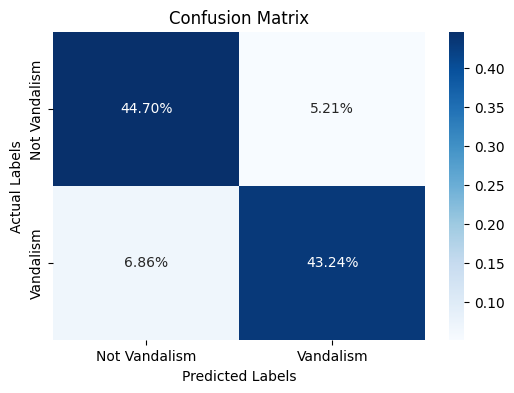

In [17]:
from evaluate_xgboost_model import (evaluate_train_test_metrics, calculate_auc_scores,
                                    plot_confusion_matrix)

# Evaluate Train and Test Metrics
y_test_pred, y_test_prob = evaluate_train_test_metrics(final_tuned_model, X_train, y_train, X_test, y_test)

# Calculate AUC Scores and Get Confusion Matrix
cm = calculate_auc_scores(y_test, y_test_pred, y_test_prob)

# Plot Confusion Matrix
plot_confusion_matrix(cm)

In [18]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_test_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


Matthews Correlation Coefficient: 0.7591


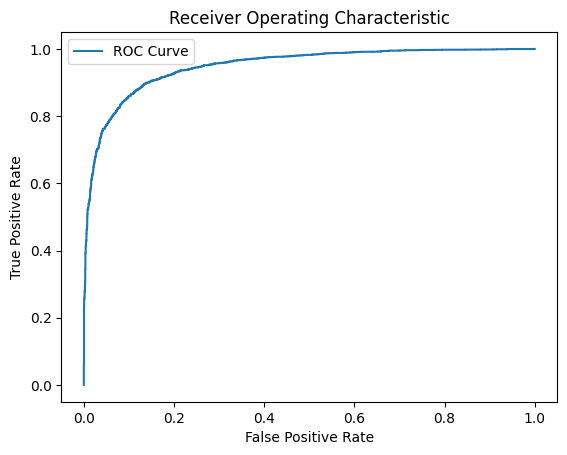

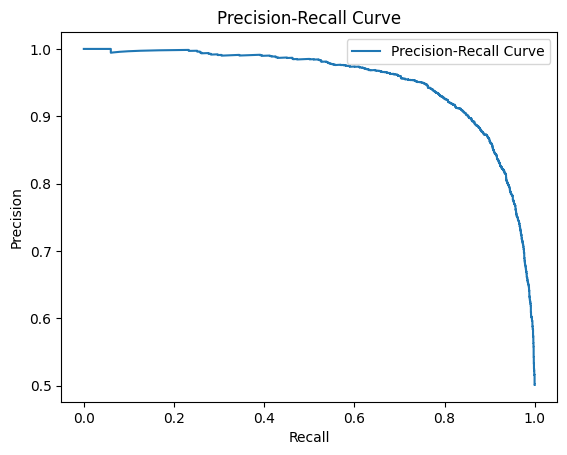

In [19]:
from model.evaluate_xgboost_model import plot_roc_pr_curves

plot_roc_pr_curves(y_test, y_test_prob)

### Bootstrapping

In [20]:
from evaluate_data_set.bootstrap_evaluation import (
    perform_bootstrap_evaluation,
    calculate_bootstrap_statistics,
    plot_metric_distributions,
    compute_additional_statistics,
    save_bootstrap_results
)

In [21]:
# Assuming you have your trained model and test data
metrics_df = perform_bootstrap_evaluation(
    model=final_base_model,
    X_test=X_test,
    y_test=y_test,
    n_iterations=1000,
    random_state=42  # Optional for reproducibility
)

In [22]:
results_df = calculate_bootstrap_statistics(metrics_df)
print("Bootstrap Performance Metrics on Test Set:")
print(results_df)

Bootstrap Performance Metrics on Test Set:
      Metric      Mean   Std Dev  95% CI Lower  95% CI Upper
0   Accuracy  0.816694  0.005213      0.806508      0.826397
1  Precision  0.824293  0.007213      0.810415      0.837696
2     Recall  0.805922  0.007221      0.791483      0.819543
3   F1-score  0.814979  0.005667      0.803715      0.825282
4    AUC-ROC  0.896720  0.004071      0.888529      0.904083
5     AUC-PR  0.901881  0.004831      0.892316      0.911038


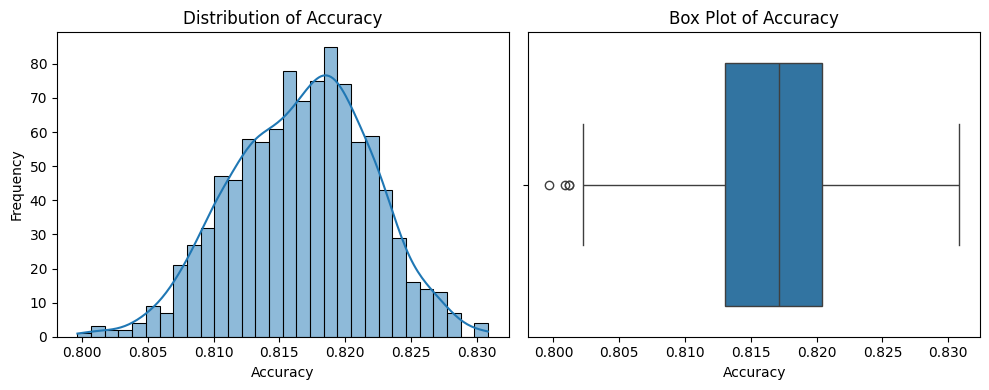

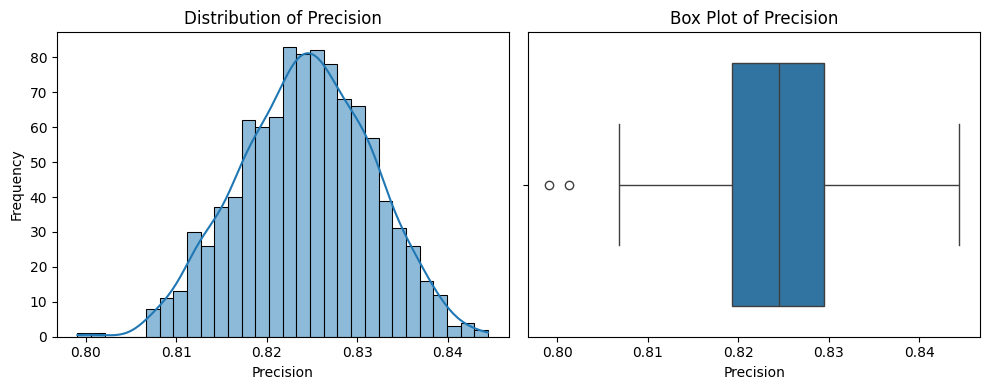

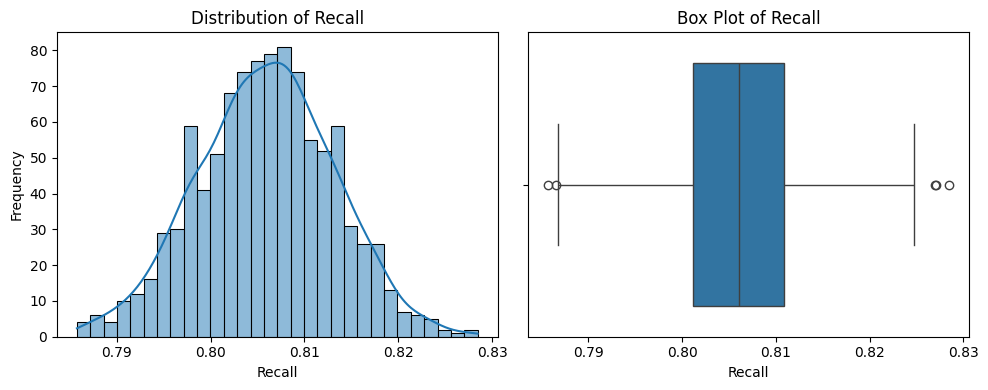

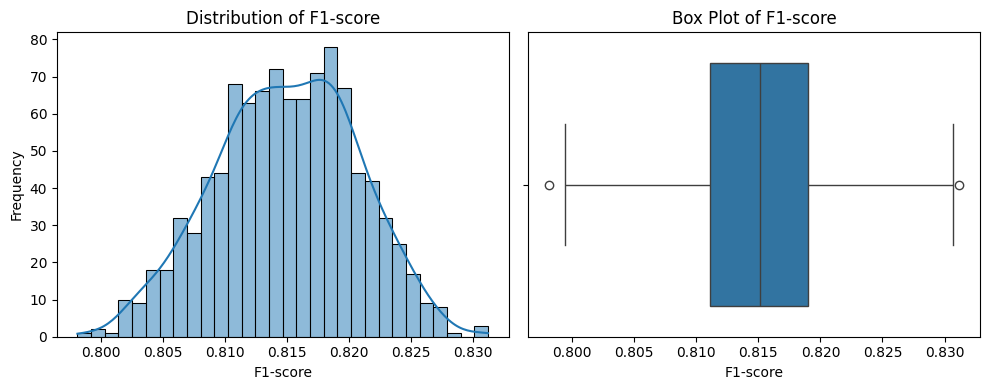

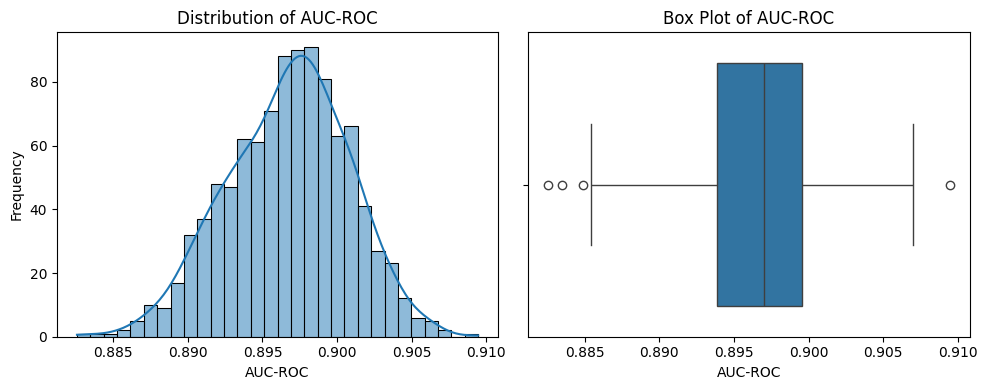

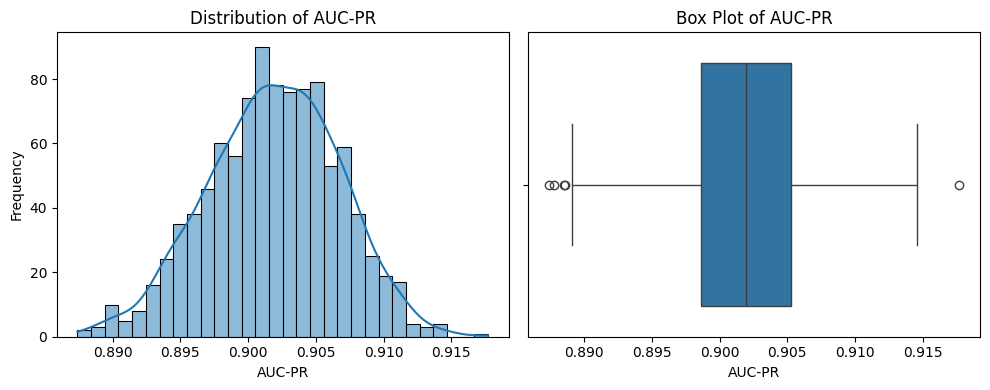

In [23]:
plot_metric_distributions(metrics_df)

In [24]:
stats_df = compute_additional_statistics(metrics_df)
print("Additional Statistics for Each Metric:")
print(stats_df)

Additional Statistics for Each Metric:
      Metric  Skewness  Kurtosis Normal Distribution  Normality p-value
0   Accuracy -0.177546 -0.230728                  No           0.020593
1  Precision -0.100409 -0.278799                 Yes           0.058110
2     Recall -0.027002 -0.133072                 Yes           0.674755
3   F1-score -0.108618 -0.385445                  No           0.004022
4    AUC-ROC -0.207435 -0.137908                  No           0.019709
5     AUC-PR -0.144411 -0.167782                 Yes           0.097489


In [25]:
folder_to_save_bootstrap_results = '../saved_parameters/changeset_model/bootstrapping'
save_bootstrap_results(metrics_df, results_df, stats_df, folder_to_save_bootstrap_results, prefix='bootstrap_test_set')

Directory already exists at: ../saved_parameters/changeset_model/bootstrapping
Results saved in saved_parameters with prefix "../saved_parameters/changeset_model/bootstrapping/bootstrap_test_set"


### Continent Evaluation

In [26]:
# Import necessary libraries and the module
import pandas as pd
import xgboost as xgb
import evaluate_data_set.continent_evaluation as ce

# Ensure X_test and y_test are defined and include bounding box fields
# If necessary, load your test data here

# Convert X_test to DataFrame if it's not already
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=final_base_model.get_booster().feature_names)

# Step 1: Calculate center coordinates
X_test = ce.calculate_center_coordinates(X_test, xmin_col='xmin', xmax_col='xmax', ymin_col='ymin', ymax_col='ymax')

# Step 2: Assign continents
X_test = ce.assign_continents(X_test)

# Step 3: Split test set by continent
continent_data = ce.split_test_set_by_continent(X_test, y_test)

# Step 4: Evaluate model on each continent
results = ce.evaluate_model_on_continents(continent_data, final_tuned_model)

# Step 5: Analyze the results
results_df = pd.DataFrame.from_dict(results, orient='index')
print("\nModel Performance on Each Continent:")
display(results_df)

KeyError: 'xmin'

In [ ]:
# Plotting Accuracy across Continents
import matplotlib.pyplot as plt

results_df['Accuracy'].plot(kind='bar', figsize=(10,6))
plt.title('Model Accuracy on Each Continent')
plt.xlabel('Continent')
plt.ylabel('Accuracy')
plt.show()